In [1]:
%reload_ext autoreload
%autoreload 2
%cd ../
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

/home/hazzu/Code/thesis


In [2]:
import cv2
import numpy as np


def visualize_result(
    image1: cv2.typing.MatLike,
    face1: list[float],
    image2: cv2.typing.MatLike,
    face2: list[float],
    similarity: float,
    is_match: bool,
):
    drawed_image1 = image1.copy()
    drawed_image2 = image2.copy()

    x1, y1, w1, h1 = map(int, face1[:4])
    x2, y2, w2, h2 = map(int, face2[:4])

    color = (0, 0, 255)
    if is_match:
        color = (0, 255, 0)

    drawed_image1 = cv2.rectangle(drawed_image1, (x1, y1), (x1 + w1, y1 + h1), color, 2)
    drawed_image2 = cv2.rectangle(drawed_image2, (x2, y2), (x2 + w2, y2 + h2), color, 2)
    drawed_image1 = cv2.putText(
        drawed_image1,
        f"Similarity: {similarity}",
        (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        color,
        2,
    )

    h1, w1 = drawed_image1.shape[:2]
    h2, w2 = drawed_image2.shape[:2]
    vis = np.zeros((max(h1, h2), w1 + w2, 3), np.uint8)
    vis[:h1, :w1, :3] = drawed_image1
    vis[:h2, w1 : w1 + w2, :3] = drawed_image2

    return vis

# 1. Tạo cặp genuine và imposter pairs


In [3]:
# import os

# CARD_DIR = "datasets/cards"
# SELFIE_DIR = "datasets/selfies"

# genuine_pairs = []
# selfie_names = os.listdir(SELFIE_DIR)

# for card_name in os.listdir(CARD_DIR):
#     student_id = card_name.split("_")[0]
#     card_path = os.path.join(CARD_DIR, card_name)

#     _selfie_names = list(filter(lambda x: student_id in x, selfie_names))
#     if len(_selfie_names) == 0:
#         continue

#     _selfie_name = _selfie_names[0]
#     _selfie_path = os.path.join(SELFIE_DIR, _selfie_name)
#     for img_name in os.listdir(_selfie_path):
#         img_path = os.path.join(_selfie_path, img_name)
#         genuine_pairs.append((card_path, img_path))

# print(len(genuine_pairs))

285


In [ ]:
# from random import shuffle
# from pathlib import Path

# imposter_pairs_card = [card_path for (card_path, _) in genuine_pairs]
# imposter_pairs_selfie = [selfie_path for (_, selfie_path) in genuine_pairs]


# def check():
#     results = [
#         Path(selfie_path).parts[2].split("_")[0] in card_path
#         for (card_path, selfie_path) in zip(imposter_pairs_card, imposter_pairs_selfie)
#     ]
#     return any(results)


# while check():
#     shuffle(imposter_pairs_selfie)

# imposter_pairs = list(zip(imposter_pairs_card, imposter_pairs_selfie))
# print(len(imposter_pairs))

285


In [5]:
# import pandas as pd

# genuine_pairs = pd.DataFrame(genuine_pairs, columns=["card", "selfie"])
# imposter_pairs = pd.DataFrame(imposter_pairs, columns=["card", "selfie"])

# genuine_pairs.to_csv("datasets/genuine_pairs.csv", index=False)
# imposter_pairs.to_csv("datasets/imposter_pairs.csv", index=False)

In [6]:
import pandas as pd

genuine_pairs_df = pd.read_csv("datasets/genuine_pairs.csv")
imposter_pairs_df = pd.read_csv("datasets/imposter_pairs.csv")

genuine_pairs = list(zip(genuine_pairs_df["card"], genuine_pairs_df["selfie"]))
imposter_pairs = list(zip(imposter_pairs_df["card"], imposter_pairs_df["selfie"]))

# 2. Tính cosine similarity


## 2.1. YuNet + SFace


In [8]:
from tqdm import tqdm
import os, cv2, timeit
from pathlib import Path
from lib.sface import SFace
from lib.FaceDetector import YuNetDetector

yunet = YuNetDetector()
embedder = SFace(modelPath="weights/face_recognition_sface_2021dec.onnx")


def test(is_genuine_pairs=True):
    results = []

    for card_path, selfie_path in tqdm(
        genuine_pairs if is_genuine_pairs else imposter_pairs
    ):
        card_image = cv2.imread(card_path)
        selfie_image = cv2.imread(selfie_path)

        begin = timeit.default_timer()

        face_in_card, scale = yunet.detect_single_multiscale(card_image)
        if face_in_card is None:
            print(f"Cannot detect face in card {card_path}")
            continue
        scaled_card_image = cv2.resize(
            card_image,
            (int(scale * card_image.shape[1]), int(scale * card_image.shape[0])),
        )

        face_in_selfie, scale2 = yunet.detect_single_multiscale(selfie_image)
        if face_in_selfie is None:
            print(f"Cannot detect face in selfie {selfie_path}")
            continue
        scaled_selfie_image = cv2.resize(
            selfie_image,
            (int(scale2 * selfie_image.shape[1]), int(scale2 * selfie_image.shape[0])),
        )

        similarity, is_match = embedder.match(
            scaled_card_image, face_in_card, scaled_selfie_image, face_in_selfie
        )

        end = timeit.default_timer()

        results.append((card_path, selfie_path, similarity, end - begin))

        vs = visualize_result(
            scaled_card_image,
            face_in_card,
            scaled_selfie_image,
            face_in_selfie,
            similarity,
            is_match,
        )
        os.makedirs(
            f"results/face-verification/yunet_sface/{"genuine_pairs" if is_genuine_pairs else "imposter_pairs"}",
            exist_ok=True,
        )
        cv2.imwrite(
            f"results/face-verification/yunet_sface/{"genuine_pairs" if is_genuine_pairs else "imposter_pairs"}/{Path(card_path).stem}_{Path(selfie_path).stem}.jpg",
            vs,
        )

    results_df = pd.DataFrame(
        results, columns=["card", "selfie", "similarity", "inference_time"]
    )
    results_df.to_csv(
        f"results/face-verification/yunet_sface/{"genuine_pairs" if is_genuine_pairs else "imposter_pairs"}.csv",
        index=False,
    )


test(is_genuine_pairs=True)
test(is_genuine_pairs=False)

100%|██████████| 285/285 [02:15<00:00,  2.11it/s]


## 2.2. RetinaFace + ArcFace


In [9]:
import os, cv2
from tqdm import tqdm
from pathlib import Path
from deepface import DeepFace


def test2(is_genuine_pairs=True):
    results = []

    for card_path, selfie_path in tqdm(
        genuine_pairs if is_genuine_pairs else imposter_pairs
    ):
        card_image = cv2.imread(card_path)
        selfie_image = cv2.imread(selfie_path)

        result = DeepFace.verify(
            img1_path=card_path,
            img2_path=selfie_path,
            model_name="ArcFace",
            detector_backend="retinaface",
            silent=True,
        )

        distance = result["distance"]
        similarity = 1 - distance
        is_match = result["verified"]
        time = result["time"]

        face_in_card = result["facial_areas"]["img1"]
        face_in_selfie = result["facial_areas"]["img2"]
        face_in_card = [
            face_in_card["x"],
            face_in_card["y"],
            face_in_card["w"],
            face_in_card["h"],
        ]
        face_in_selfie = [
            face_in_selfie["x"],
            face_in_selfie["y"],
            face_in_selfie["w"],
            face_in_selfie["h"],
        ]

        vis = visualize_result(
            card_image,
            face_in_card,
            selfie_image,
            face_in_selfie,
            similarity,
            is_match,
        )

        results.append((card_path, selfie_path, similarity, time))

        os.makedirs(
            f"results/face-verification/retinaface_arcface/{"genuine_pairs" if is_genuine_pairs else "imposter_pairs"}",
            exist_ok=True,
        )
        cv2.imwrite(
            f"results/face-verification/retinaface_arcface/{"genuine_pairs" if is_genuine_pairs else "imposter_pairs"}/{Path(card_path).stem}_{Path(selfie_path).stem}.jpg",
            vis,
        )

    results_df = pd.DataFrame(
        results, columns=["card", "selfie", "similarity", "inference_time"]
    )
    results_df.to_csv(
        f"results/face-verification/retinaface_arcface/{"genuine_pairs" if is_genuine_pairs else "imposter_pairs"}.csv",
        index=False,
    )


test2(is_genuine_pairs=True)
test2(is_genuine_pairs=False)

2025-02-02 19:51:28.096433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738500688.110644  124978 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738500688.116040  124978 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-02 19:51:28.141163: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 285/285 [19:21<00:00,  4.08s/it]


# 3. Tính toán các chỉ số đánh giá


In [10]:
import pandas as pd

yunet_sface_genuine = pd.read_csv(
    "results/face-verification/yunet_sface/genuine_pairs.csv"
)
yunet_sface_imposter = pd.read_csv(
    "results/face-verification/yunet_sface/imposter_pairs.csv"
)

retinaface_arcface_genuine = pd.read_csv(
    "results/face-verification/retinaface_arcface/genuine_pairs.csv"
)
retinaface_arcface_imposter = pd.read_csv(
    "results/face-verification/retinaface_arcface/imposter_pairs.csv"
)

## 3.1. Inference time


In [11]:
import numpy as np

yunet_sface_inference_time = [
    *yunet_sface_genuine["inference_time"],
    *yunet_sface_imposter["inference_time"],
]

retinaface_arcface_inference_time = [
    *retinaface_arcface_genuine["inference_time"],
    *retinaface_arcface_imposter["inference_time"],
]

print(
    f"Inference time (Yunet + SFace): {np.mean(yunet_sface_inference_time) * 1000:.0f}ms"
)
print(
    f"Inference time (RetinaFace + ArcFace): {np.mean(retinaface_arcface_inference_time) * 1000:.0f}ms"
)

Inference time (Yunet + SFace): 486ms
Inference time (RetinaFace + ArcFace): 4119ms


## 3.2. AUC - ROC


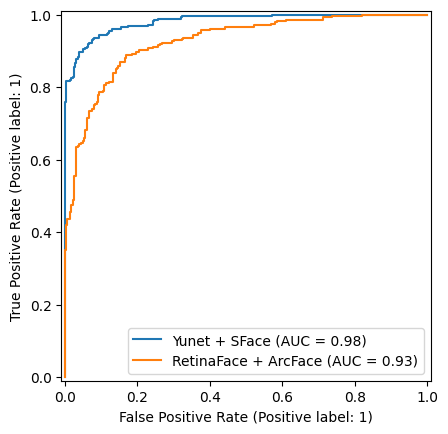

In [12]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

yunet_sface_y_true = [1] * len(yunet_sface_genuine) + [0] * len(yunet_sface_imposter)
yunet_sface_y_score = [
    *yunet_sface_genuine["similarity"],
    *yunet_sface_imposter["similarity"],
]

retinaface_arcface_y_true = [1] * len(retinaface_arcface_genuine) + [0] * len(
    retinaface_arcface_imposter
)
retinaface_arcface_y_score = [
    *retinaface_arcface_genuine["similarity"],
    *retinaface_arcface_imposter["similarity"],
]

fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(
    yunet_sface_y_true, yunet_sface_y_score, name="Yunet + SFace", ax=ax
)
RocCurveDisplay.from_predictions(
    retinaface_arcface_y_true,
    retinaface_arcface_y_score,
    name="RetinaFace + ArcFace",
    ax=ax,
)

plt.show()

## 3.3. EER


In [13]:
import numpy as np


def calc_far_frr(genuine_pred_score, imposter_score, threshold):
    genuine_pred = genuine_pred_score >= threshold
    imposter_pred = imposter_score >= threshold

    false_accept = np.sum(imposter_pred)
    false_reject = np.sum(genuine_pred == False)

    far = false_accept / len(imposter_pred)
    frr = false_reject / len(genuine_pred)

    return (far, frr)

In [24]:
import numpy as np

thresholds = np.arange(0, 0.6, 0.001)

yunet_sface_genuine_score = yunet_sface_genuine["similarity"]
yunet_sface_imposter_score = yunet_sface_imposter["similarity"]

yunet_sface_far = []
yunet_sface_frr = []

for threshold in thresholds:
    far, frr = calc_far_frr(
        yunet_sface_genuine_score, yunet_sface_imposter_score, threshold
    )
    yunet_sface_far.append(far)
    yunet_sface_frr.append(frr)

err_ = np.abs(np.array(yunet_sface_far) - np.array(yunet_sface_frr))
eer_thres = thresholds[np.argmin(err_)]
eer = (yunet_sface_far[np.argmin(err_)] + yunet_sface_frr[np.argmin(err_)]) / 2

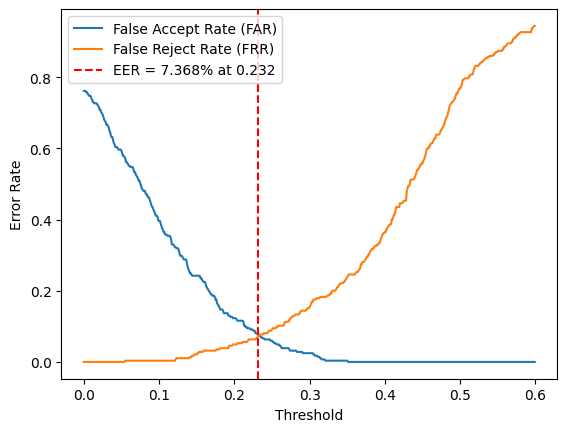

In [25]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(thresholds, yunet_sface_far, label="False Accept Rate (FAR)")
ax.plot(thresholds, yunet_sface_frr, label="False Reject Rate (FRR)")
ax.axvline(
    eer_thres,
    color="red",
    linestyle="--",
    label=f"EER = {eer * 100:.3f}% at {eer_thres:.3f}",
)
ax.legend()
ax.set_xlabel("Threshold")
ax.set_ylabel("Error Rate")

plt.show()

In [26]:
import numpy as np

thresholds = np.arange(0, 0.6, 0.001)

retinaface_arcface_genuine_score = retinaface_arcface_genuine["similarity"]
retinaface_arcface_imposter_score = retinaface_arcface_imposter["similarity"]

retinaface_arcface_far = []
retinaface_arcface_frr = []

for threshold in thresholds:
    far, frr = calc_far_frr(
        retinaface_arcface_genuine_score, retinaface_arcface_imposter_score, threshold
    )
    retinaface_arcface_far.append(far)
    retinaface_arcface_frr.append(frr)

err_ = np.abs(np.array(retinaface_arcface_far) - np.array(retinaface_arcface_frr))
eer_thres = thresholds[np.argmin(err_)]
eer = (
    retinaface_arcface_far[np.argmin(err_)] + retinaface_arcface_frr[np.argmin(err_)]
) / 2

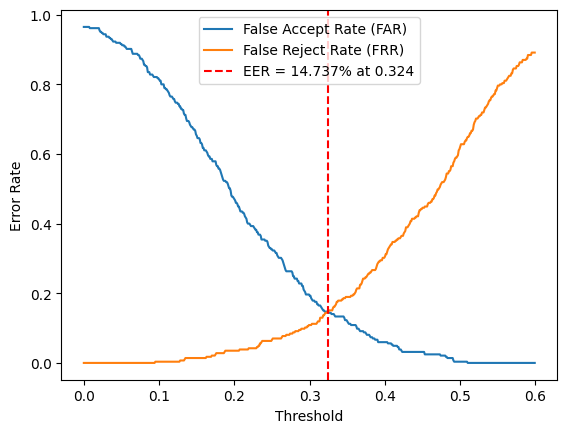

In [27]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(thresholds, retinaface_arcface_far, label="False Accept Rate (FAR)")
ax.plot(thresholds, retinaface_arcface_frr, label="False Reject Rate (FRR)")
ax.axvline(
    eer_thres,
    color="red",
    linestyle="--",
    label=f"EER = {eer * 100:.3f}% at {eer_thres:.3f}",
)
ax.legend()
ax.set_xlabel("Threshold")
ax.set_ylabel("Error Rate")

plt.show()